In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from ae import AutoEncoder
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import os
from utils import scheduler, plot_manifold, plot_history, plot_rescontruction_and_actual_images, mse

### 1. Load and preprocess data

In [2]:
exclude_class_0 = True

(x_train, train_labels), (x_test, test_labels) = mnist.load_data()

if exclude_class_0:
    x_train = x_train[train_labels != 0]
    train_labels = train_labels[train_labels != 0]

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

permutation = np.random.permutation(len(x_train))
x_train, train_labels = x_train[permutation], train_labels[permutation]
permutation = np.random.permutation(len(x_test))
x_test, test_labels = x_test[permutation], test_labels[permutation]

### 2. Create and train model

In [3]:
# Create model 
cfg = {
    'latent_dim': 2
}
autoencoder = AutoEncoder(cfg)
autoencoder.compile(optimizer='adam', loss='mse')
lr_scheduler = LearningRateScheduler(scheduler)
history = autoencoder.fit(x=x_train, y=x_train,
                          epochs=30,
                          batch_size=512,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          callbacks=[lr_scheduler])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 model (Functional)          (None, 2)                 308506    
                                                                 
 model_1 (Functional)        (None, 784)               309288    
                                                                 
Total params: 617,794
Trainable params: 617,794
Non-trainable params: 0
_________________________________________________________________
SimpleAutoEncoder, Model summary:  None
Epoch 1/30
106/106 [==============================] - 1s 9ms/step - loss: 0.0794 - val_loss: 0.0642 - lr: 0.0010
Epoch 2/30
106/106 [==============================] - 1s 8ms/step - loss: 0.0588 - val_loss: 0.0594 - lr: 0.0010
Epoch 3/30
106/106 [==============================]

# Research questions

1. Graph the area of the manifold.

2. Calculate the average of the difference between the input and the output

3. Determine the difference between the trained data and the untrained data

4. See what happens when you give the untrained data (0) as input.

### Analysis 1: Graph the area of the manifold
If using latent dimension > 2, please uncomment #latent_transform = TSNE(n_components=2).fit_transform(x_latent) in utils.py and replace 'x_latent' by 'latent_transform'

313/313 [==============================] - 0s 505us/step


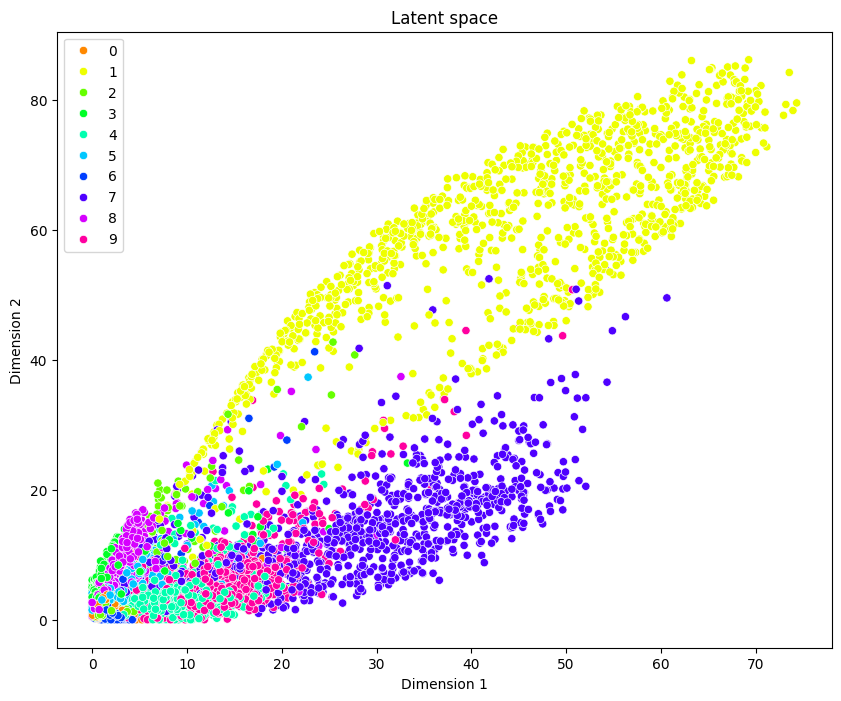

In [4]:
plot_manifold(autoencoder, x_test, test_labels)

### Analysis 2: Calculate the average of the difference between the input and the output

In [5]:
mse_classes = dict()
reconstructed_images = autoencoder.predict(x=x_test)
for r_img, x_t, label in zip(reconstructed_images, x_test, test_labels):
    if label not in mse_classes:
        mse_classes[label] = [mse(r_img, x_t)]
    else:
        mse_classes[label].append(mse(r_img, x_t))
        
avg_mse_classes = dict()
for key, values in mse_classes.items():
    avg_mse_classes[key] = np.mean(values)

avg_mse_classes = dict(sorted(avg_mse_classes.items(), key= lambda x: x[0]))

313/313 [==============================] - 0s 706us/step


In [6]:
for key, value in avg_mse_classes.items():
    print('Averge mse of class {}: {}'.format(key, value))

Averge mse of class 0: 0.08049777034106682
Averge mse of class 1: 0.014486781523142719
Averge mse of class 2: 0.060550188489827725
Averge mse of class 3: 0.047987501320230004
Averge mse of class 4: 0.044055865554327146
Averge mse of class 5: 0.05127911033024054
Averge mse of class 6: 0.04948201765005521
Averge mse of class 7: 0.03703847573796789
Averge mse of class 8: 0.052617073593841414
Averge mse of class 9: 0.038101695755422035


### Analysis 3: Determine the difference between the trained data and the untrained data

====> The average MSE of class 0 is larger than all other classes

### Analysis 4: Reconstruction vs Actual images from test data

1/1 [==============================] - 0s 8ms/step


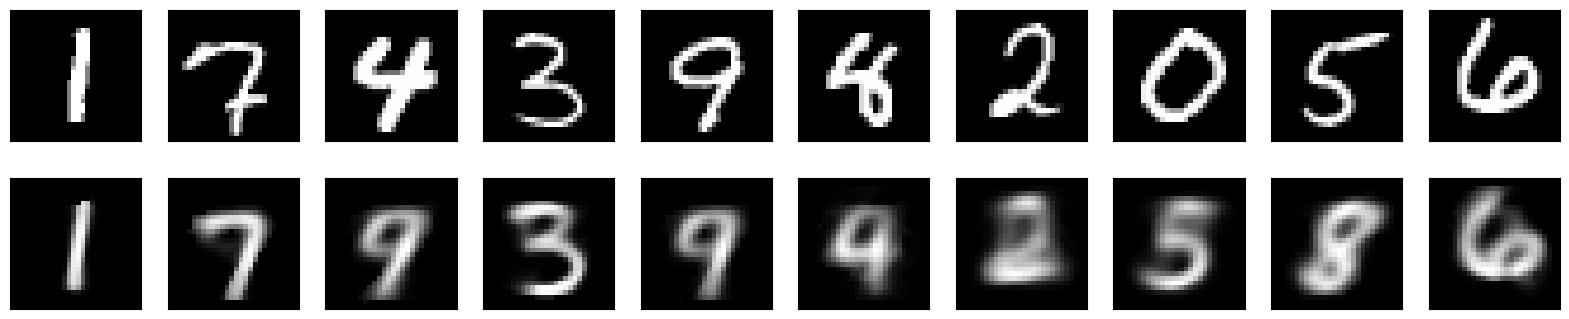

In [7]:
plot_rescontruction_and_actual_images(autoencoder, x_test, test_labels)